# SSL Models Performance Analysis on SurgVU Dataset

This notebook analyzes the performance of Self-Supervised Learning (SSL) models trained on the SurgVU dataset.

## Data Sources:
1. **train_val_results.csv** - validation results during training
2. **test_results.csv** - evaluation results on test set

## Models:
- **ImageNet** - weights pre-trained on ImageNet
- **MoCo** - Momentum Contrast 
- **SimCLR** - Simple Contrastive Learning

## Data Subsets:
- **12.5%** - 1/8 of training data
- **25%** - 1/4 of training data  
- **100%** - full training data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

print("📊 SSL Models Performance Analysis on SurgVU Dataset")
print("="*60)

📊 SSL Models Performance Analysis on SurgVU Dataset


## 1. Data Loading and Preparation

In [6]:
# Paths to CSV files in results subdirectory
train_val_file = "../../results/train_val_results.csv"
test_eval_file = "../../results/test_results.csv"

# Check if files exist
print("🔍 Checking files:")
print(f"Train/Val results: {os.path.exists(train_val_file)} - {train_val_file}")
print(f"Test eval results: {os.path.exists(test_eval_file)} - {test_eval_file}")

# Load data
print("\n📁 Loading data...")

# 1. Training/validation data
df_train_val = pd.read_csv(train_val_file)
print(f"✅ Train/Val data: {df_train_val.shape[0]} rows, {df_train_val.shape[1]} columns")

# 2. Test data
df_test = pd.read_csv(test_eval_file)
print(f"✅ Test data: {df_test.shape[0]} rows, {df_test.shape[1]} columns")

print("\n📋 Data preview:")
print("\n--- Train/Val Results ---")
print(df_train_val.head())
print("\n--- Test Evaluation Results ---")
print(df_test.head())

🔍 Checking files:
Train/Val results: True - ../../results/train_val_results.csv
Test eval results: True - ../../results/test_results.csv

📁 Loading data...
✅ Train/Val data: 9 rows, 14 columns
✅ Test data: 9 rows, 10 columns

📋 Data preview:

--- Train/Val Results ---
      model data_subset              job_directory  \
0  ImageNet       12.5%  job_1952602_20251015_1437   
1  ImageNet         25%  job_1952603_20251015_1437   
2  ImageNet        100%  job_1952604_20251015_1437   
3      MoCo       12.5%  job_1953621_20251016_1141   
4      MoCo         25%  job_1953622_20251016_1141   

                                            job_path  \
0  /net/tscratch/people/plgjmachali/surgvu_result...   
1  /net/tscratch/people/plgjmachali/surgvu_result...   
2  /net/tscratch/people/plgjmachali/surgvu_result...   
3  /net/tscratch/people/plgjmachali/surgvu_result...   
4  /net/tscratch/people/plgjmachali/surgvu_result...   

                                     checkpoint_path  checkpoint_exis

In [7]:
# Rename columns for clarity: test_* -> val_* (these are validation results, not test results)
print("🔧 Data preparation...")
print("📝 Renaming columns for clarity: test_* -> val_*")

# Rename validation columns in train_val data
df_train_val = df_train_val.rename(columns={
    'test_f1_macro': 'val_f1_macro',
    'test_f1_weighted': 'val_f1_weighted', 
    'test_accuracy': 'val_accuracy'
})

# Prepare test data - remove unnecessary columns
df_test_clean = df_test[['model', 'data_subset', 'phase', 'test_f1_macro', 'test_f1_weighted', 'test_accuracy']].copy()

# Normalize model names (if needed)
model_mapping = {
    'ImageNet': 'ImageNet',
    'MoCo': 'MoCo', 
    'SimCLR': 'SimCLR'
}

# Define consistent colors for all models across all visualizations
model_colors = {'ImageNet': '#1f77b4', 'MoCo': '#ff7f0e', 'SimCLR': '#2ca02c'}
print("🎨 Defined consistent color scheme:")
for model, color in model_colors.items():
    print(f"  {model}: {color}")

# Set category order for X-axis
subset_order = ["12.5%", "25%", "100%"]
df_train_val["data_subset"] = pd.Categorical(df_train_val["data_subset"], categories=subset_order, ordered=True)
df_test_clean["data_subset"] = pd.Categorical(df_test_clean["data_subset"], categories=subset_order, ordered=True)

# Check unique values
print(f"\n📊 Models in train/val: {df_train_val['model'].unique()}")
print(f"📊 Models in test: {df_test_clean['model'].unique()}")
print(f"📊 Data subsets: {subset_order}")
print(f"✅ Column renaming completed - now using: val_f1_macro, val_f1_weighted, val_accuracy")

🔧 Data preparation...
📝 Renaming columns for clarity: test_* -> val_*
🎨 Defined consistent color scheme:
  ImageNet: #1f77b4
  MoCo: #ff7f0e
  SimCLR: #2ca02c

📊 Models in train/val: ['ImageNet' 'MoCo' 'SimCLR']
📊 Models in test: ['ImageNet' 'MoCo' 'SimCLR']
📊 Data subsets: ['12.5%', '25%', '100%']
✅ Column renaming completed - now using: val_f1_macro, val_f1_weighted, val_accuracy


## 2. Validation Results Visualization (Train/Val)

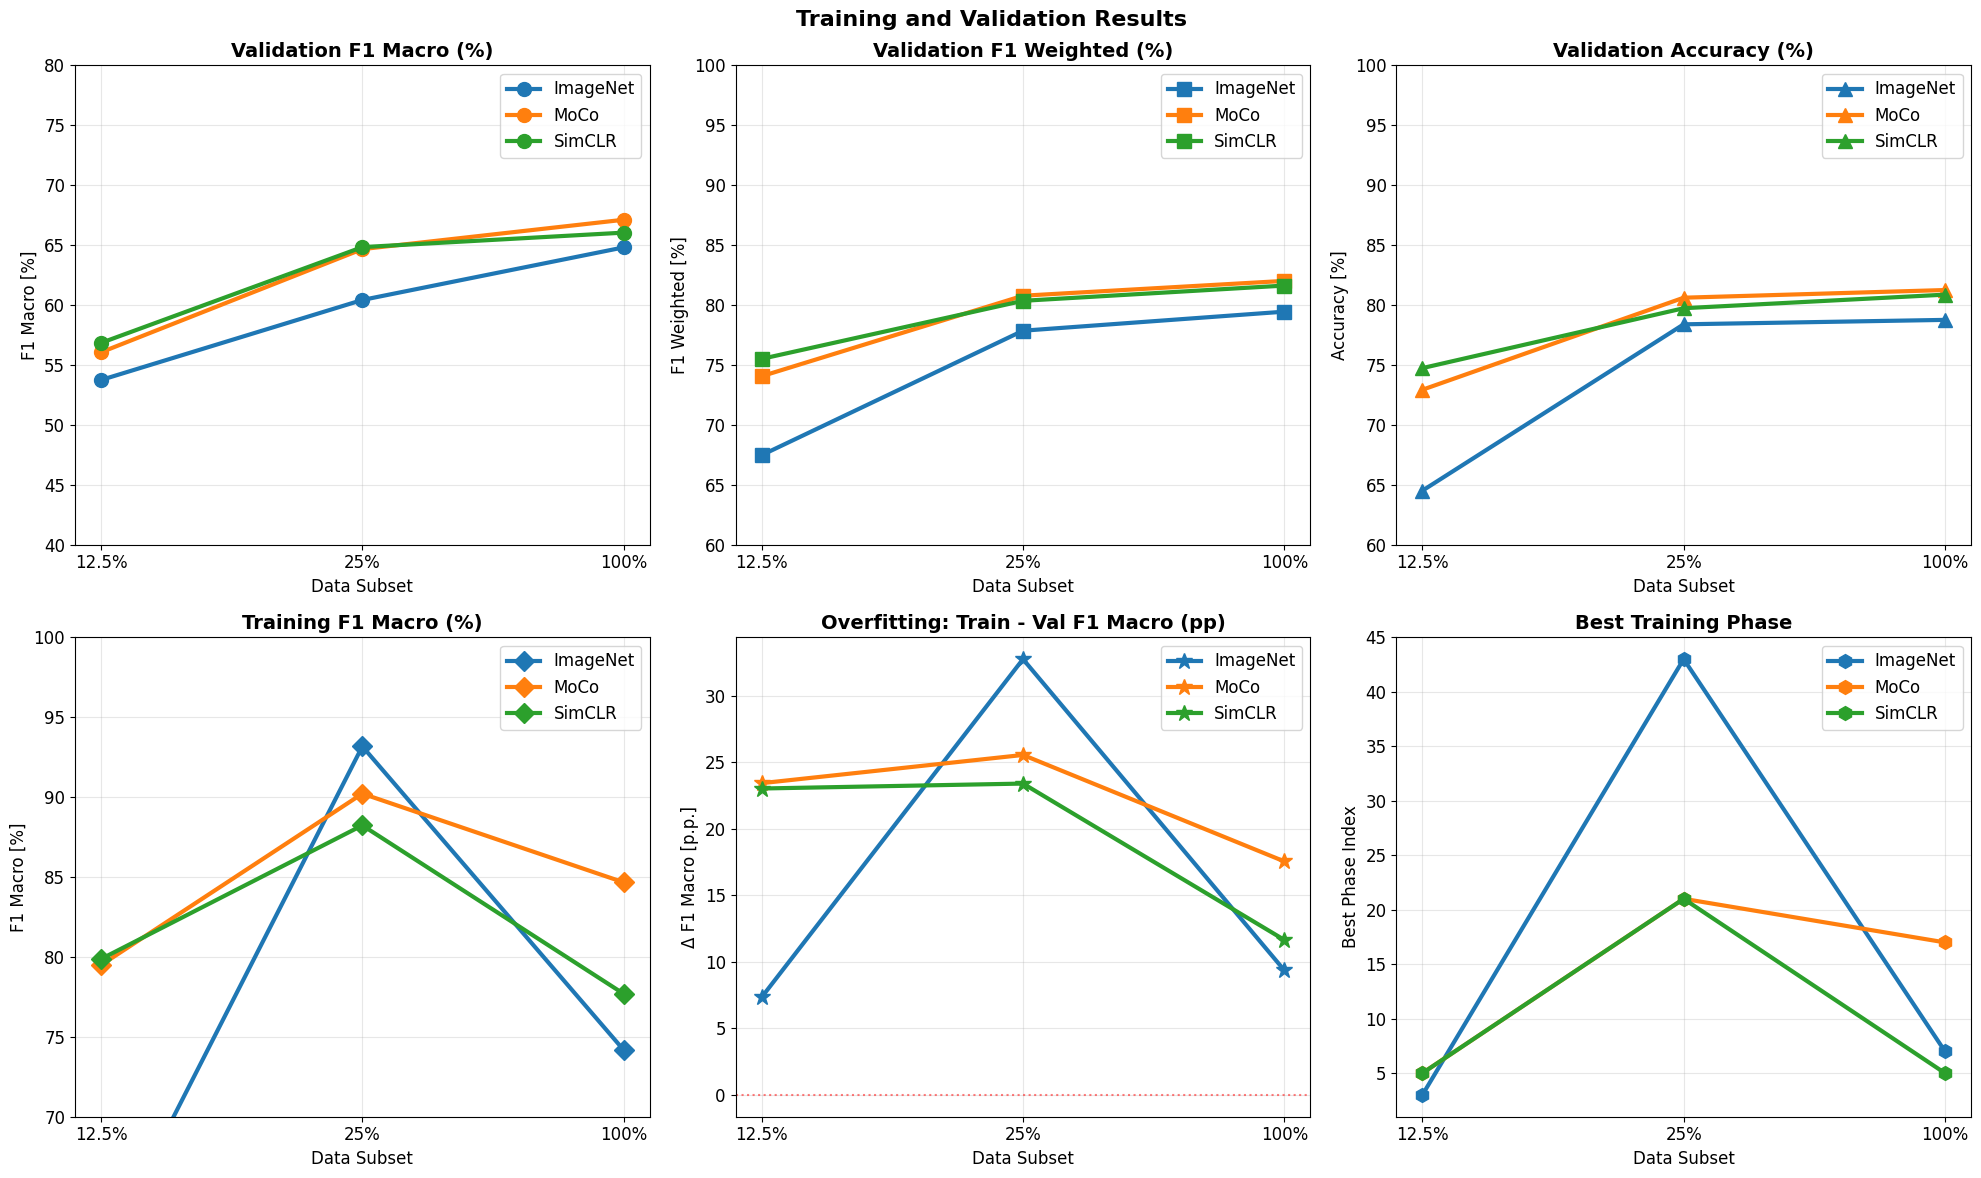

In [8]:
# Define consistent colors for models
model_colors = {'ImageNet': '#1f77b4', 'MoCo': '#ff7f0e', 'SimCLR': '#2ca02c'}

# Visualization of train/val results
plt.figure(figsize=(20, 12))

# 1) Validation F1 Macro
ax1 = plt.subplot(2, 3, 1)
for model, group in df_train_val.groupby("model"):
    group = group.sort_values("data_subset")
    ax1.plot(group["data_subset"], group["val_f1_macro"],
             marker="o", linewidth=3, markersize=10, label=model, color=model_colors[model])
ax1.set_title("Validation F1 Macro (%)", fontsize=14, fontweight="bold")
ax1.set_xlabel("Data Subset")
ax1.set_ylabel("F1 Macro [%]")
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(40, 80)

# 2) Validation F1 Weighted
ax2 = plt.subplot(2, 3, 2)
for model, group in df_train_val.groupby("model"):
    group = group.sort_values("data_subset")
    ax2.plot(group["data_subset"], group["val_f1_weighted"],
             marker="s", linewidth=3, markersize=10, label=model, color=model_colors[model])
ax2.set_title("Validation F1 Weighted (%)", fontsize=14, fontweight="bold")
ax2.set_xlabel("Data Subset")
ax2.set_ylabel("F1 Weighted [%]")
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(60, 100)

# 3) Validation Accuracy
ax3 = plt.subplot(2, 3, 3)
for model, group in df_train_val.groupby("model"):
    group = group.sort_values("data_subset")
    ax3.plot(group["data_subset"], group["val_accuracy"],
             marker="^", linewidth=3, markersize=10, label=model, color=model_colors[model])
ax3.set_title("Validation Accuracy (%)", fontsize=14, fontweight="bold")
ax3.set_xlabel("Data Subset")
ax3.set_ylabel("Accuracy [%]")
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_ylim(60, 100)

# 4) Train F1 Macro
ax4 = plt.subplot(2, 3, 4)
for model, group in df_train_val.groupby("model"):
    group = group.sort_values("data_subset")
    ax4.plot(group["data_subset"], group["train_f1_macro"],
             marker="D", linewidth=3, markersize=10, label=model, color=model_colors[model])
ax4.set_title("Training F1 Macro (%)", fontsize=14, fontweight="bold")
ax4.set_xlabel("Data Subset")
ax4.set_ylabel("F1 Macro [%]")
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.set_ylim(70, 100)

# 5) Overfitting (Train - Val F1 Macro)
ax5 = plt.subplot(2, 3, 5)
for model, group in df_train_val.groupby("model"):
    group = group.sort_values("data_subset")
    overfit = group["train_f1_macro"].values - group["val_f1_macro"].values
    ax5.plot(group["data_subset"], overfit,
             marker="*", linewidth=3, markersize=12, label=model, color=model_colors[model])
ax5.set_title("Overfitting: Train - Val F1 Macro (pp)", fontsize=14, fontweight="bold")
ax5.set_xlabel("Data Subset")
ax5.set_ylabel("Δ F1 Macro [p.p.]")
ax5.axhline(y=0, linestyle=":", alpha=0.5, color='red')
ax5.grid(True, alpha=0.3)
ax5.legend()

# 6) Best Phase
ax6 = plt.subplot(2, 3, 6)
for model, group in df_train_val.groupby("model"):
    group = group.sort_values("data_subset")
    ax6.plot(group["data_subset"], group["best_phase"].astype(int),
             marker="h", linewidth=3, markersize=10, label=model, color=model_colors[model])    
ax6.set_title("Best Training Phase", fontsize=14, fontweight="bold")
ax6.set_xlabel("Data Subset")
ax6.set_ylabel("Best Phase Index")
ax6.grid(True, alpha=0.3)
ax6.legend()

plt.suptitle("Training and Validation Results", fontsize=16, fontweight="bold", y=0.98)
plt.tight_layout()
plt.show()

## 3. Test Set Results Visualization

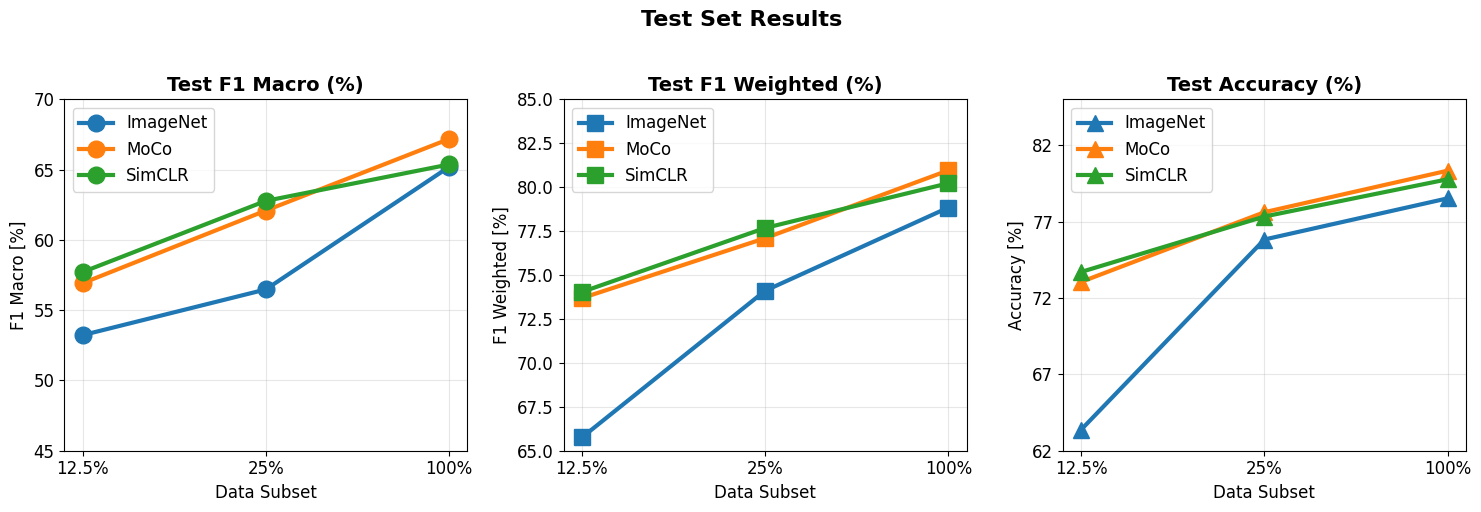

In [9]:
# Visualization of test results
plt.figure(figsize=(15, 5))

# 1) Test F1 Macro
ax1 = plt.subplot(1, 3, 1)
for model, group in df_test_clean.groupby("model"):
    group = group.sort_values("data_subset")
    ax1.plot(group["data_subset"], group["test_f1_macro"],
             marker="o", linewidth=3, markersize=12, label=model, color=model_colors[model])
ax1.set_title("Test F1 Macro (%)", fontsize=14, fontweight="bold")
ax1.set_xlabel("Data Subset")
ax1.set_ylabel("F1 Macro [%]")
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(45, 70)

# 2) Test F1 Weighted
ax2 = plt.subplot(1, 3, 2)
for model, group in df_test_clean.groupby("model"):
    group = group.sort_values("data_subset")
    ax2.plot(group["data_subset"], group["test_f1_weighted"],
             marker="s", linewidth=3, markersize=12, label=model, color=model_colors[model])
ax2.set_title("Test F1 Weighted (%)", fontsize=14, fontweight="bold")
ax2.set_xlabel("Data Subset")
ax2.set_ylabel("F1 Weighted [%]")
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(65, 85)

# 3) Test Accuracy
ax3 = plt.subplot(1, 3, 3)
for model, group in df_test_clean.groupby("model"):
    group = group.sort_values("data_subset")
    ax3.plot(group["data_subset"], group["test_accuracy"],
             marker="^", linewidth=3, markersize=12, label=model, color=model_colors[model])
ax3.set_title("Test Accuracy (%)", fontsize=14, fontweight="bold")
ax3.set_xlabel("Data Subset")
ax3.set_ylabel("Accuracy [%]")
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_ylim(62, 85)
ax3.set_yticks(np.arange(62, 85, 5))

plt.suptitle("Test Set Results", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## 4. Validation vs Test Comparison

In [10]:
# Combine data for Val vs Test comparison
# Prepare comparison data
comparison_data = []

for _, row_val in df_train_val.iterrows():
    model = row_val['model']
    subset = row_val['data_subset']
    
    # Find corresponding row in test data
    test_row = df_test_clean[(df_test_clean['model'] == model) & 
                            (df_test_clean['data_subset'] == subset)]
    
    if not test_row.empty:
        test_row = test_row.iloc[0]
        comparison_data.append({
            'model': model,
            'data_subset': subset,
            'val_f1_macro': row_val['val_f1_macro'],  # using renamed column
            'test_f1_macro': test_row['test_f1_macro'],
            'val_f1_weighted': row_val['val_f1_weighted'],  # using renamed column
            'test_f1_weighted': test_row['test_f1_weighted'], 
            'val_accuracy': row_val['val_accuracy'],  # using renamed column
            'test_accuracy': test_row['test_accuracy']
        })

df_comparison = pd.DataFrame(comparison_data)
df_comparison["data_subset"] = pd.Categorical(df_comparison["data_subset"], categories=subset_order, ordered=True)

print("📊 Prepared comparison data Val vs Test")
print(f"Shape: {df_comparison.shape}")
print("\nPreview:")
print(df_comparison.head())

📊 Prepared comparison data Val vs Test
Shape: (9, 8)

Preview:
      model data_subset  val_f1_macro  test_f1_macro  val_f1_weighted  \
0  ImageNet       12.5%     53.743988      53.222131        67.475332   
1  ImageNet         25%     60.420523      56.474658        77.857857   
2  ImageNet        100%     64.809127      65.188500        79.446512   
3      MoCo       12.5%     56.055963      56.920143        74.060891   
4      MoCo         25%     64.665731      62.085538        80.777248   

   test_f1_weighted  val_accuracy  test_accuracy  
0         65.754207       64.5076        63.3804  
1         74.104327       78.3905        75.8246  
2         78.838536       78.7604        78.5186  
3         73.685535       72.9294        73.0514  
4         77.095946       80.6107        77.6118  


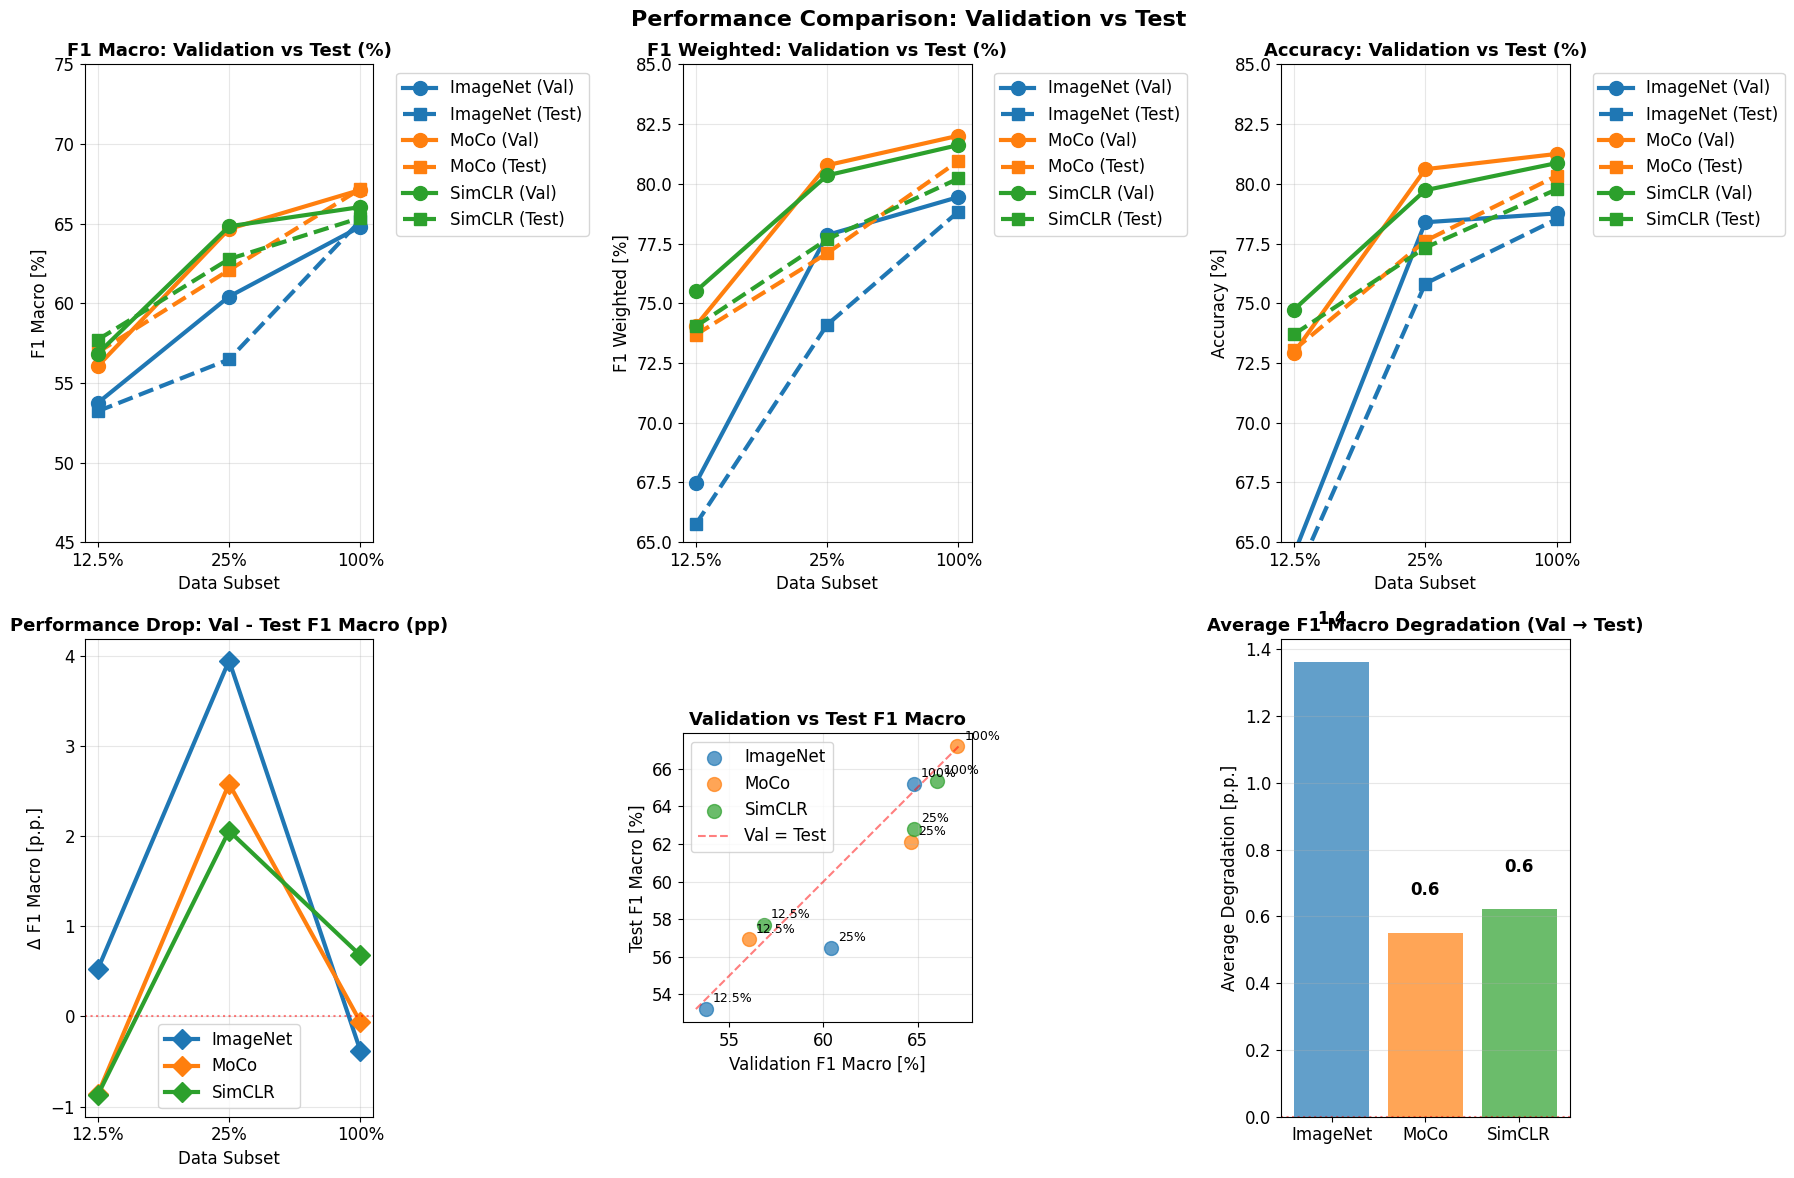

In [11]:
# Visualization of Val vs Test comparison
plt.figure(figsize=(18, 12))

# 1) F1 Macro: Val vs Test
ax1 = plt.subplot(2, 3, 1)
for model, group in df_comparison.groupby("model"):
    group = group.sort_values("data_subset")
    ax1.plot(group["data_subset"], group["val_f1_macro"],
             marker="o", linewidth=3, markersize=10, label=f"{model} (Val)", 
             linestyle='-', color=model_colors[model])
    ax1.plot(group["data_subset"], group["test_f1_macro"],
             marker="s", linewidth=3, markersize=8, label=f"{model} (Test)", 
             linestyle='--', color=model_colors[model])
ax1.set_title("F1 Macro: Validation vs Test (%)", fontsize=13, fontweight="bold")
ax1.set_xlabel("Data Subset")
ax1.set_ylabel("F1 Macro [%]")
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax1.set_ylim(45, 75)

# 2) F1 Weighted: Val vs Test
ax2 = plt.subplot(2, 3, 2)
for model, group in df_comparison.groupby("model"):
    group = group.sort_values("data_subset")
    ax2.plot(group["data_subset"], group["val_f1_weighted"],
             marker="o", linewidth=3, markersize=10, label=f"{model} (Val)", 
             linestyle='-', color=model_colors[model])
    ax2.plot(group["data_subset"], group["test_f1_weighted"],
             marker="s", linewidth=3, markersize=8, label=f"{model} (Test)", 
             linestyle='--', color=model_colors[model])
ax2.set_title("F1 Weighted: Validation vs Test (%)", fontsize=13, fontweight="bold")
ax2.set_xlabel("Data Subset")
ax2.set_ylabel("F1 Weighted [%]")
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax2.set_ylim(65, 85)

# 3) Accuracy: Val vs Test
ax3 = plt.subplot(2, 3, 3)
for model, group in df_comparison.groupby("model"):
    group = group.sort_values("data_subset")
    ax3.plot(group["data_subset"], group["val_accuracy"],
             marker="o", linewidth=3, markersize=10, label=f"{model} (Val)", 
             linestyle='-', color=model_colors[model])
    ax3.plot(group["data_subset"], group["test_accuracy"],
             marker="s", linewidth=3, markersize=8, label=f"{model} (Test)", 
             linestyle='--', color=model_colors[model])
ax3.set_title("Accuracy: Validation vs Test (%)", fontsize=13, fontweight="bold")
ax3.set_xlabel("Data Subset")
ax3.set_ylabel("Accuracy [%]")
ax3.grid(True, alpha=0.3)
ax3.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax3.set_ylim(65, 85)

# 4) Performance Drop: Val - Test F1 Macro
ax4 = plt.subplot(2, 3, 4)
for model, group in df_comparison.groupby("model"):
    group = group.sort_values("data_subset")
    degradation = group["val_f1_macro"].values - group["test_f1_macro"].values
    ax4.plot(group["data_subset"], degradation,
             marker="D", linewidth=3, markersize=10, label=model, color=model_colors[model])
ax4.set_title("Performance Drop: Val - Test F1 Macro (pp)", fontsize=13, fontweight="bold")
ax4.set_xlabel("Data Subset")
ax4.set_ylabel("Δ F1 Macro [p.p.]")
ax4.axhline(y=0, linestyle=":", alpha=0.5, color='red')
ax4.grid(True, alpha=0.3)
ax4.legend()

# 5) Scatter: Val vs Test F1 Macro
ax5 = plt.subplot(2, 3, 5)
for model, group in df_comparison.groupby("model"):
    ax5.scatter(group["val_f1_macro"], group["test_f1_macro"], 
                s=100, alpha=0.7, label=model, color=model_colors[model])
    
    # Add text with subset name
    for _, row in group.iterrows():
        ax5.annotate(row["data_subset"], 
                    (row["val_f1_macro"], row["test_f1_macro"]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

# Perfect line (Val = Test)
min_val = min(df_comparison["val_f1_macro"].min(), df_comparison["test_f1_macro"].min())
max_val = max(df_comparison["val_f1_macro"].max(), df_comparison["test_f1_macro"].max())
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Val = Test')

ax5.set_title("Validation vs Test F1 Macro", fontsize=13, fontweight="bold")
ax5.set_xlabel("Validation F1 Macro [%]")
ax5.set_ylabel("Test F1 Macro [%]")
ax5.grid(True, alpha=0.3)
ax5.legend()
ax5.set_aspect('equal')

# 6) Bar plot: Average degradation per model
ax6 = plt.subplot(2, 3, 6)
model_degradation = []
model_names = []
bar_colors = []
for model, group in df_comparison.groupby("model"):
    avg_degradation = (group["val_f1_macro"] - group["test_f1_macro"]).mean()
    model_degradation.append(avg_degradation)
    model_names.append(model)
    bar_colors.append(model_colors[model])

bars = ax6.bar(model_names, model_degradation, alpha=0.7, color=bar_colors)
ax6.set_title("Average F1 Macro Degradation (Val → Test)", fontsize=13, fontweight="bold")
ax6.set_ylabel("Average Degradation [p.p.]")
ax6.axhline(y=0, linestyle=":", alpha=0.5, color='red')
ax6.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar, val in zip(bars, model_degradation):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle("Performance Comparison: Validation vs Test", fontsize=16, fontweight="bold", y=0.98)
plt.tight_layout()
plt.show()

In [12]:
# Detailed numerical comparisons for LLM analysis
print("="*80)
print("📊 DETAILED COMPARISON ANALYSIS - VALIDATION vs TEST PERFORMANCE")
print("="*80)

print("\n🔸 1. INDIVIDUAL MODEL PERFORMANCE BY DATA SUBSET:")
print("-"*60)

for subset in subset_order:
    print(f"\n📈 DATA SUBSET: {subset}")
    print("="*40)
    
    subset_comparison = df_comparison[df_comparison["data_subset"] == subset]
    
    for _, row in subset_comparison.iterrows():
        model = row["model"]
        val_f1 = row["val_f1_macro"]
        test_f1 = row["test_f1_macro"]
        degradation = val_f1 - test_f1
        
        val_f1_weighted = row["val_f1_weighted"]
        test_f1_weighted = row["test_f1_weighted"]
        degradation_weighted = val_f1_weighted - test_f1_weighted
        
        val_acc = row["val_accuracy"]
        test_acc = row["test_accuracy"]
        degradation_acc = val_acc - test_acc
        
        print(f"\n{model}:")
        print(f"  F1 Macro:     Val={val_f1:.2f}%  Test={test_f1:.2f}%  Drop={degradation:.2f}pp")
        print(f"  F1 Weighted:  Val={val_f1_weighted:.2f}%  Test={test_f1_weighted:.2f}%  Drop={degradation_weighted:.2f}pp")
        print(f"  Accuracy:     Val={val_acc:.2f}%  Test={test_acc:.2f}%  Drop={degradation_acc:.2f}pp")

print("\n\n🔸 2. CROSS-MODEL COMPARISON BY METRIC:")
print("-"*60)

# F1 Macro comparison
print(f"\n📊 F1 MACRO COMPARISON:")
print("Model".ljust(12) + "12.5% Val".ljust(12) + "12.5% Test".ljust(12) + "25% Val".ljust(12) + "25% Test".ljust(12) + "100% Val".ljust(12) + "100% Test".ljust(12))
print("-" * 84)

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model].sort_values("data_subset")
    line = model.ljust(12)
    
    for _, row in model_data.iterrows():
        line += f"{row['val_f1_macro']:.1f}".ljust(12)
        line += f"{row['test_f1_macro']:.1f}".ljust(12)
    
    print(line)

# F1 Weighted comparison
print(f"\n📊 F1 WEIGHTED COMPARISON:")
print("Model".ljust(12) + "12.5% Val".ljust(12) + "12.5% Test".ljust(12) + "25% Val".ljust(12) + "25% Test".ljust(12) + "100% Val".ljust(12) + "100% Test".ljust(12))
print("-" * 84)

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model].sort_values("data_subset")
    line = model.ljust(12)
    
    for _, row in model_data.iterrows():
        line += f"{row['val_f1_weighted']:.1f}".ljust(12)
        line += f"{row['test_f1_weighted']:.1f}".ljust(12)
    
    print(line)

# Accuracy comparison
print(f"\n📊 ACCURACY COMPARISON:")
print("Model".ljust(12) + "12.5% Val".ljust(12) + "12.5% Test".ljust(12) + "25% Val".ljust(12) + "25% Test".ljust(12) + "100% Val".ljust(12) + "100% Test".ljust(12))
print("-" * 84)

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model].sort_values("data_subset")
    line = model.ljust(12)
    
    for _, row in model_data.iterrows():
        line += f"{row['val_accuracy']:.1f}".ljust(12)
        line += f"{row['test_accuracy']:.1f}".ljust(12)
    
    print(line)

print("\n\n🔸 3. PERFORMANCE DEGRADATION ANALYSIS:")
print("-"*60)

print(f"\n📉 AVERAGE DEGRADATION BY MODEL (Val → Test):")
for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model]
    
    avg_f1_drop = (model_data["val_f1_macro"] - model_data["test_f1_macro"]).mean()
    avg_f1w_drop = (model_data["val_f1_weighted"] - model_data["test_f1_weighted"]).mean()
    avg_acc_drop = (model_data["val_accuracy"] - model_data["test_accuracy"]).mean()
    
    print(f"\n{model}:")
    print(f"  F1 Macro Drop:    {avg_f1_drop:.2f} pp")
    print(f"  F1 Weighted Drop: {avg_f1w_drop:.2f} pp")
    print(f"  Accuracy Drop:    {avg_acc_drop:.2f} pp")

print(f"\n📉 DEGRADATION BY DATA SUBSET:")
for subset in subset_order:
    subset_data = df_comparison[df_comparison["data_subset"] == subset]
    
    avg_f1_drop = (subset_data["val_f1_macro"] - subset_data["test_f1_macro"]).mean()
    avg_f1w_drop = (subset_data["val_f1_weighted"] - subset_data["test_f1_weighted"]).mean()
    avg_acc_drop = (subset_data["val_accuracy"] - subset_data["test_accuracy"]).mean()
    
    print(f"\n{subset} Data:")
    print(f"  Avg F1 Macro Drop:    {avg_f1_drop:.2f} pp")
    print(f"  Avg F1 Weighted Drop: {avg_f1w_drop:.2f} pp")
    print(f"  Avg Accuracy Drop:    {avg_acc_drop:.2f} pp")

print("\n\n🔸 4. RANKING ANALYSIS:")
print("-"*60)

print(f"\n🏆 BEST MODELS BY METRIC AND SUBSET (Test Results):")

for subset in subset_order:
    subset_data = df_test_clean[df_test_clean["data_subset"] == subset]
    
    best_f1_macro = subset_data.loc[subset_data["test_f1_macro"].idxmax()]
    best_f1_weighted = subset_data.loc[subset_data["test_f1_weighted"].idxmax()]
    best_accuracy = subset_data.loc[subset_data["test_accuracy"].idxmax()]
    
    print(f"\n{subset} Data:")
    print(f"  Best F1 Macro:    {best_f1_macro['model']} ({best_f1_macro['test_f1_macro']:.2f}%)")
    print(f"  Best F1 Weighted: {best_f1_weighted['model']} ({best_f1_weighted['test_f1_weighted']:.2f}%)")
    print(f"  Best Accuracy:    {best_accuracy['model']} ({best_accuracy['test_accuracy']:.2f}%)")

print(f"\n🔄 CONSISTENCY ANALYSIS:")
print(f"Models that achieve best performance across multiple metrics/subsets:")

# Count wins per model
model_wins = {'ImageNet': 0, 'MoCo': 0, 'SimCLR': 0}

for subset in subset_order:
    subset_data = df_test_clean[df_test_clean["data_subset"] == subset]
    
    best_f1_macro_model = subset_data.loc[subset_data["test_f1_macro"].idxmax(), "model"]
    best_f1_weighted_model = subset_data.loc[subset_data["test_f1_weighted"].idxmax(), "model"]
    best_accuracy_model = subset_data.loc[subset_data["test_accuracy"].idxmax(), "model"]
    
    model_wins[best_f1_macro_model] += 1
    model_wins[best_f1_weighted_model] += 1
    model_wins[best_accuracy_model] += 1

print(f"\nTotal wins (across all metrics and subsets):")
for model, wins in sorted(model_wins.items(), key=lambda x: x[1], reverse=True):
    print(f"  {model}: {wins}/9 possible wins")

print("\n" + "="*80)
print("✅ DETAILED COMPARISON ANALYSIS COMPLETED")
print("="*80)

📊 DETAILED COMPARISON ANALYSIS - VALIDATION vs TEST PERFORMANCE

🔸 1. INDIVIDUAL MODEL PERFORMANCE BY DATA SUBSET:
------------------------------------------------------------

📈 DATA SUBSET: 12.5%

ImageNet:
  F1 Macro:     Val=53.74%  Test=53.22%  Drop=0.52pp
  F1 Weighted:  Val=67.48%  Test=65.75%  Drop=1.72pp
  Accuracy:     Val=64.51%  Test=63.38%  Drop=1.13pp

MoCo:
  F1 Macro:     Val=56.06%  Test=56.92%  Drop=-0.86pp
  F1 Weighted:  Val=74.06%  Test=73.69%  Drop=0.38pp
  Accuracy:     Val=72.93%  Test=73.05%  Drop=-0.12pp

SimCLR:
  F1 Macro:     Val=56.84%  Test=57.71%  Drop=-0.87pp
  F1 Weighted:  Val=75.51%  Test=74.03%  Drop=1.47pp
  Accuracy:     Val=74.74%  Test=73.70%  Drop=1.03pp

📈 DATA SUBSET: 25%

ImageNet:
  F1 Macro:     Val=60.42%  Test=56.47%  Drop=3.95pp
  F1 Weighted:  Val=77.86%  Test=74.10%  Drop=3.75pp
  Accuracy:     Val=78.39%  Test=75.82%  Drop=2.57pp

MoCo:
  F1 Macro:     Val=64.67%  Test=62.09%  Drop=2.58pp
  F1 Weighted:  Val=80.78%  Test=77.10%  Drop

In [13]:
print("="*80)
print("📈 ADVANCED STATISTICAL ANALYSIS FOR LLM INTERPRETATION")
print("="*80)

print("\n🔸 1. STATISTICAL SUMMARY OF PERFORMANCE GAPS:")
print("-"*60)

# Calculate overall statistics
f1_macro_gaps = df_comparison["val_f1_macro"] - df_comparison["test_f1_macro"]
f1_weighted_gaps = df_comparison["val_f1_weighted"] - df_comparison["test_f1_weighted"]
accuracy_gaps = df_comparison["val_accuracy"] - df_comparison["test_accuracy"]

print(f"\nF1 Macro (Val-Test) Gap Statistics:")
print(f"  Mean: {f1_macro_gaps.mean():.2f} pp")
print(f"  Std:  {f1_macro_gaps.std():.2f} pp")
print(f"  Min:  {f1_macro_gaps.min():.2f} pp")
print(f"  Max:  {f1_macro_gaps.max():.2f} pp")

print(f"\nF1 Weighted (Val-Test) Gap Statistics:")
print(f"  Mean: {f1_weighted_gaps.mean():.2f} pp")
print(f"  Std:  {f1_weighted_gaps.std():.2f} pp")
print(f"  Min:  {f1_weighted_gaps.min():.2f} pp")
print(f"  Max:  {f1_weighted_gaps.max():.2f} pp")

print(f"\nAccuracy (Val-Test) Gap Statistics:")
print(f"  Mean: {accuracy_gaps.mean():.2f} pp")
print(f"  Std:  {accuracy_gaps.std():.2f} pp")
print(f"  Min:  {accuracy_gaps.min():.2f} pp")
print(f"  Max:  {accuracy_gaps.max():.2f} pp")

print("\n🔸 2. DATA SCALING EFFECTS ANALYSIS:")
print("-"*60)

print(f"\nPerformance scaling with data size (Test F1 Macro):")
for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_test_clean[df_test_clean["model"] == model].sort_values("data_subset")
    scores = model_data["test_f1_macro"].values
    
    improvement_12_to_25 = scores[1] - scores[0] if len(scores) > 1 else 0
    improvement_25_to_100 = scores[2] - scores[1] if len(scores) > 2 else 0
    total_improvement = scores[-1] - scores[0] if len(scores) > 1 else 0
    
    print(f"\n{model}:")
    print(f"  12.5% → 25%:   {improvement_12_to_25:+.2f} pp ({scores[0]:.2f}% → {scores[1]:.2f}%)")
    print(f"  25% → 100%:    {improvement_25_to_100:+.2f} pp ({scores[1]:.2f}% → {scores[2]:.2f}%)")
    print(f"  Total gain:    {total_improvement:+.2f} pp ({scores[0]:.2f}% → {scores[-1]:.2f}%)")

print("\n🔸 3. OVERFITTING ANALYSIS:")
print("-"*60)

# Calculate overfitting from training data
print(f"\nOverfitting Analysis (Train - Val F1 Macro):")
for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_train_val[df_train_val["model"] == model].sort_values("data_subset")
    
    print(f"\n{model}:")
    for _, row in model_data.iterrows():
        train_f1 = row["train_f1_macro"]
        val_f1 = row["val_f1_macro"]
        overfitting = train_f1 - val_f1
        
        print(f"  {row['data_subset']} data: Train={train_f1:.2f}% Val={val_f1:.2f}% Gap={overfitting:.2f}pp")

print("\n🔸 4. RELATIVE PERFORMANCE RANKING:")
print("-"*60)

print(f"\nRank matrix by Test F1 Macro (1=best, 3=worst):")
print("Subset".ljust(12) + "ImageNet".ljust(12) + "MoCo".ljust(12) + "SimCLR".ljust(12))
print("-" * 48)

for subset in subset_order:
    subset_data = df_test_clean[df_test_clean["data_subset"] == subset].sort_values("test_f1_macro", ascending=False)
    
    # Create ranking
    ranks = {}
    for rank, (_, row) in enumerate(subset_data.iterrows(), 1):
        ranks[row["model"]] = rank
    
    line = subset.ljust(12)
    for model in ['ImageNet', 'MoCo', 'SimCLR']:
        line += str(ranks.get(model, "-")).ljust(12)
    
    print(line)

print("\n🔸 5. PERFORMANCE CONSISTENCY METRICS:")
print("-"*60)

print(f"\nCoefficient of Variation (CV) across data subsets:")
print("Lower CV = more consistent performance across different data sizes")

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_test_clean[df_test_clean["model"] == model]
    
    f1_macro_cv = (model_data["test_f1_macro"].std() / model_data["test_f1_macro"].mean()) * 100
    f1_weighted_cv = (model_data["test_f1_weighted"].std() / model_data["test_f1_weighted"].mean()) * 100
    accuracy_cv = (model_data["test_accuracy"].std() / model_data["test_accuracy"].mean()) * 100
    
    print(f"\n{model}:")
    print(f"  F1 Macro CV:    {f1_macro_cv:.2f}%")
    print(f"  F1 Weighted CV: {f1_weighted_cv:.2f}%")
    print(f"  Accuracy CV:    {accuracy_cv:.2f}%")

print("\n🔸 6. GENERALIZATION GAP ANALYSIS:")
print("-"*60)

print(f"\nGeneralization Gap (Validation vs Test) by model:")
print("Smaller gap = better generalization from validation to test")

for model in ['ImageNet', 'MoCo', 'SimCLR']:
    model_data = df_comparison[df_comparison["model"] == model]
    
    avg_f1_gap = (model_data["val_f1_macro"] - model_data["test_f1_macro"]).mean()
    std_f1_gap = (model_data["val_f1_macro"] - model_data["test_f1_macro"]).std()
    
    print(f"\n{model}:")
    print(f"  Mean F1 Macro Gap: {avg_f1_gap:.2f} ± {std_f1_gap:.2f} pp")
    
    # Show individual gaps
    for _, row in model_data.iterrows():
        gap = row["val_f1_macro"] - row["test_f1_macro"]
        print(f"    {row['data_subset']}: {gap:.2f} pp")

print("\n" + "="*80)
print("✅ ADVANCED STATISTICAL ANALYSIS COMPLETED")
print("="*80)

📈 ADVANCED STATISTICAL ANALYSIS FOR LLM INTERPRETATION

🔸 1. STATISTICAL SUMMARY OF PERFORMANCE GAPS:
------------------------------------------------------------

F1 Macro (Val-Test) Gap Statistics:
  Mean: 0.84 pp
  Std:  1.67 pp
  Min:  -0.87 pp
  Max:  3.95 pp

F1 Weighted (Val-Test) Gap Statistics:
  Mean: 1.86 pp
  Std:  1.24 pp
  Min:  0.38 pp
  Max:  3.75 pp

Accuracy (Val-Test) Gap Statistics:
  Mean: 1.36 pp
  Std:  1.07 pp
  Min:  -0.12 pp
  Max:  3.00 pp

🔸 2. DATA SCALING EFFECTS ANALYSIS:
------------------------------------------------------------

Performance scaling with data size (Test F1 Macro):

ImageNet:
  12.5% → 25%:   +3.25 pp (53.22% → 56.47%)
  25% → 100%:    +8.71 pp (56.47% → 65.19%)
  Total gain:    +11.97 pp (53.22% → 65.19%)

MoCo:
  12.5% → 25%:   +5.17 pp (56.92% → 62.09%)
  25% → 100%:    +5.09 pp (62.09% → 67.18%)
  Total gain:    +10.26 pp (56.92% → 67.18%)

SimCLR:
  12.5% → 25%:   +5.06 pp (57.71% → 62.77%)
  25% → 100%:    +2.59 pp (62.77% → 65.36

## 5. Summary Tables

In [14]:
# Summary tables
print("=" * 100)
print("📊 SUMMARY TABLE - VALIDATION RESULTS (Train/Val)")
print("=" * 100)
print(df_train_val.round(2).to_string(index=False))

print("\n" + "=" * 100)
print("📊 SUMMARY TABLE - TEST RESULTS")
print("=" * 100)
print(df_test_clean.round(2).to_string(index=False))

print("\n" + "=" * 100)
print("📊 COMPARISON TABLE - VALIDATION vs TEST")
print("=" * 100)
print(df_comparison.round(2).to_string(index=False))

📊 SUMMARY TABLE - VALIDATION RESULTS (Train/Val)
   model data_subset             job_directory                                                                                                    job_path                                                                                                                checkpoint_path  checkpoint_exists  best_phase  best_train_phase  val_f1_macro  val_f1_weighted  val_accuracy  train_f1_macro  train_f1_weighted  train_accuracy
ImageNet       12.5% job_1952602_20251015_1437  /net/tscratch/people/plgjmachali/surgvu_results/finetuning/imagenet_to_surgvu/12/job_1952602_20251015_1437  /net/tscratch/people/plgjmachali/surgvu_results/finetuning/imagenet_to_surgvu/12/job_1952602_20251015_1437/model_phase1.torch               True           3                 1         53.74            67.48         64.51           61.09              71.28           69.52
ImageNet         25% job_1952603_20251015_1437  /net/tscratch/people/plgjmachali/surgvu_results/f

In [15]:
# Best models analysis
print("\n" + "=" * 100)
print("🏆 BEST MODELS BY DATA SUBSET (by Test F1 Macro)")
print("=" * 100)

# Best on validation
print("\n🔸 VALIDATION:")
for subset in subset_order:
    subset_data = df_train_val[df_train_val["data_subset"] == subset]
    if subset_data.empty:
        continue
    best_row = subset_data.loc[subset_data["val_f1_macro"].idxmax()]
    print(f"\n{subset} Data:")
    print(f"  🥇 Best Model: {best_row['model']}")
    print(f"  📊 Val F1 Macro: {best_row['val_f1_macro']:.2f}%")
    print(f"  📊 Val F1 Weighted: {best_row['val_f1_weighted']:.2f}%")
    print(f"  📊 Val Accuracy: {best_row['val_accuracy']:.2f}%")
    print(f"  🎯 Best Phase: {int(best_row['best_phase'])}")

# Best on test
print("\n🔸 TEST:")
for subset in subset_order:
    subset_data = df_test_clean[df_test_clean["data_subset"] == subset]
    if subset_data.empty:
        continue
    best_row = subset_data.loc[subset_data["test_f1_macro"].idxmax()]
    print(f"\n{subset} Data:")
    print(f"  🥇 Best Model: {best_row['model']}")
    print(f"  📊 Test F1 Macro: {best_row['test_f1_macro']:.2f}%")
    print(f"  📊 Test F1 Weighted: {best_row['test_f1_weighted']:.2f}%")
    print(f"  📊 Test Accuracy: {best_row['test_accuracy']:.2f}%")

# Overall statistics
print("\n" + "=" * 100)
print("📈 OVERALL STATISTICS")
print("=" * 100)

print("\n🔸 AVERAGE RESULTS BY MODEL (Test F1 Macro):")
test_avg = df_test_clean.groupby("model")["test_f1_macro"].mean().sort_values(ascending=False)
for model, avg_score in test_avg.items():
    print(f"  {model}: {avg_score:.2f}%")

print("\n🔸 AVERAGE DEGRADATION VAL → TEST (F1 Macro):")
for model, group in df_comparison.groupby("model"):
    avg_degradation = (group["val_f1_macro"] - group["test_f1_macro"]).mean()
    print(f"  {model}: {avg_degradation:.2f} p.p.")

print("\n🔸 BEST OVERALL RESULT:")
overall_best = df_test_clean.loc[df_test_clean["test_f1_macro"].idxmax()]
print(f"  Model: {overall_best['model']}")
print(f"  Subset: {overall_best['data_subset']}")
print(f"  Test F1 Macro: {overall_best['test_f1_macro']:.2f}%")

print("\n✅ Analysis completed!")


🏆 BEST MODELS BY DATA SUBSET (by Test F1 Macro)

🔸 VALIDATION:

12.5% Data:
  🥇 Best Model: SimCLR
  📊 Val F1 Macro: 56.84%
  📊 Val F1 Weighted: 75.51%
  📊 Val Accuracy: 74.74%
  🎯 Best Phase: 5

25% Data:
  🥇 Best Model: SimCLR
  📊 Val F1 Macro: 64.83%
  📊 Val F1 Weighted: 80.35%
  📊 Val Accuracy: 79.73%
  🎯 Best Phase: 21

100% Data:
  🥇 Best Model: MoCo
  📊 Val F1 Macro: 67.11%
  📊 Val F1 Weighted: 82.01%
  📊 Val Accuracy: 81.25%
  🎯 Best Phase: 17

🔸 TEST:

12.5% Data:
  🥇 Best Model: SimCLR
  📊 Test F1 Macro: 57.71%
  📊 Test F1 Weighted: 74.03%
  📊 Test Accuracy: 73.70%

25% Data:
  🥇 Best Model: SimCLR
  📊 Test F1 Macro: 62.77%
  📊 Test F1 Weighted: 77.68%
  📊 Test Accuracy: 77.33%

100% Data:
  🥇 Best Model: MoCo
  📊 Test F1 Macro: 67.18%
  📊 Test F1 Weighted: 80.96%
  📊 Test Accuracy: 80.33%

📈 OVERALL STATISTICS

🔸 AVERAGE RESULTS BY MODEL (Test F1 Macro):
  MoCo: 62.06%
  SimCLR: 61.95%
  ImageNet: 58.30%

🔸 AVERAGE DEGRADATION VAL → TEST (F1 Macro):
  ImageNet: 1.36 p.p.
  